In [1]:
import joblib

mlp = joblib.load("mlp_model.pkl")

In [2]:
from project import load_data


X_train, X_test, y_train, y_test = load_data()

alcohol
CL5    757
CL6    503
CL4    284
CL3    197
CL2     68
CL1     34
CL0     33
Name: count, dtype: int64
amphet
CL0    973
CL2    240
CL1    230
CL3    196
CL6    101
CL4     75
CL5     61
Name: count, dtype: int64
amyl
CL0    1298
CL2     236
CL1     210
CL3      91
CL4      24
CL5      14
CL6       3
Name: count, dtype: int64
benzos
CL0    999
CL3    234
CL2    229
CL4    119
CL1    116
CL6     95
CL5     84
Name: count, dtype: int64
caff
CL6    1379
CL5     271
CL4     106
CL3      59
CL0      27
CL2      24
CL1      10
Name: count, dtype: int64
cannabis
CL6    458
CL0    412
CL2    266
CL3    210
CL1    207
CL5    185
CL4    138
Name: count, dtype: int64
choc
CL6    805
CL5    679
CL4    295
CL3     53
CL0     32
CL2     10
CL1      2
Name: count, dtype: int64
coke
CL0    1035
CL2     267
CL3     257
CL1     160
CL4      98
CL5      40
CL6      19
Name: count, dtype: int64
crack
CL0    1621
CL2     109
CL1      67
CL3      59
CL5       9
CL4       9
CL6       2
Name: count, d

In [3]:
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=[0, 1], discretize_continuous=False)
lime_values = [dict(sorted(lime_explainer.explain_instance(x, mlp.predict_proba, num_features=12).as_list(), key=lambda x: x[0])) for x in X_test.values]


In [4]:
import shap

shap_explainer = shap.KernelExplainer(mlp.predict_proba, X_test)
shap_values = shap_explainer.shap_values(X_test)


/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using 376 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 376/376 [07:31<00:00,  1.20s/it]


In [5]:
shap_values_positive = shap_values[:, :, 1]

In [20]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, mlp_model):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(10, 32)
        self.hidden2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)  # Adjust output size based on your problem

        # Copy weights from the trained MLPClassifier
        self.hidden1.weight.data = torch.tensor(mlp_model.coefs_[0].T, dtype=torch.float32)
        self.hidden1.bias.data = torch.tensor(mlp_model.intercepts_[0], dtype=torch.float32)
        self.hidden2.weight.data = torch.tensor(mlp_model.coefs_[1].T, dtype=torch.float32)
        self.hidden2.bias.data = torch.tensor(mlp_model.intercepts_[1], dtype=torch.float32)
        self.output.weight.data = torch.tensor(mlp_model.coefs_[2].T, dtype=torch.float32)
        self.output.bias.data = torch.tensor(mlp_model.intercepts_[2], dtype=torch.float32)

    def forward(self, x):
        x = torch.sigmoid(self.hidden1(x))
        x = torch.sigmoid(self.hidden2(x))
        x = self.output(x)
        return x

# Create a PyTorch model from the scikit-learn model
torch_model = MLP(mlp)

In [21]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

In [22]:
from captum.attr import LRP
import numpy as np

lrp = LRP(torch_model)

attributions = lrp.attribute(X_test_tensor)
attributions = attributions.detach().cpu().numpy()


/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [11]:
lime_values_featureless = [list(val.values()) for val in lime_values]
lime_values_featureless[0]

[-0.11323185035737761,
 -0.0027665483793956488,
 -0.11784716806802614,
 -0.08018319970161762,
 -0.0817492145687931,
 -0.030201165944491237,
 -0.017266738418542347,
 -0.0389309911233628,
 0.13377934230745378,
 0.13368459357103085]

In [25]:
import importlib
import evaluation
importlib.reload(evaluation)

lime_evaluations, lime_fpr, lime_tpr, lime_roc_auc = evaluation.run_evaluations(lime_values_featureless, y_test.values.ravel())

/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 200}


In [24]:
shap_evaluations, shap_fpr, shap_tpr, shap_roc_auc = evaluation.run_evaluations(shap_values_positive, y_test.values.ravel())

/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 200}


In [26]:
lrp_evaluations, lrp_fpr, lrp_tpr, lrp_roc_auc = evaluation.run_evaluations(attributions, y_test.values.ravel())

/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 12, 'n_estimators': 300}


In [27]:
lime_evaluations

,k,Silhouette Kmeans,Silhouette Spectral,DBI Kmeans,DBI Spectral
0,2,0.644328,-0.258804,0.580469,1.078326
1,3,0.489122,-0.320301,0.738533,1.281068
2,4,0.357331,-0.320743,0.924052,2.468751
3,5,0.315590,-0.353234,1.012365,1.125036
4,6,0.261457,-0.350682,1.062374,1.165892
5,7,0.259129,-0.359429,1.085126,1.408931
6,8,0.235012,-0.372728,1.163238,1.158599
7,9,0.230835,-0.359607,1.188947,1.122977
8,10,0.206364,-0.360249,1.261828,1.115094


In [28]:
shap_evaluations

,k,Silhouette Kmeans,Silhouette Spectral,DBI Kmeans,DBI Spectral
0,2,0.338627,-0.010059,1.257811,0.992164
1,3,0.354353,-0.055019,1.250697,0.958223
2,4,0.294523,-0.057139,1.543319,2.088188
3,5,0.257994,-0.335061,1.566319,1.073556
4,6,0.233999,-0.330779,1.557368,1.072512
5,7,0.229890,-0.364138,1.526345,1.138040
6,8,0.224042,-0.360435,1.433094,1.209724


In [29]:
lrp_evaluations

,k,Silhouette Kmeans,Silhouette Spectral,DBI Kmeans,DBI Spectral
0,2,0.957331,-0.764900,0.329287,1.519425
1,3,0.906921,-0.757478,0.488168,1.518117
2,4,0.884465,-0.759359,0.436770,1.517370
3,5,0.880143,-0.757869,0.380867,1.516527
4,6,0.799455,-0.755242,0.430831,1.516406
5,7,0.797621,-0.752174,0.395234,1.514972
6,8,0.781691,-0.734445,0.458018,3.628349
7,9,0.779695,-0.748170,0.377793,1.514145
8,10,0.706336,-0.737022,0.434384,1.729993


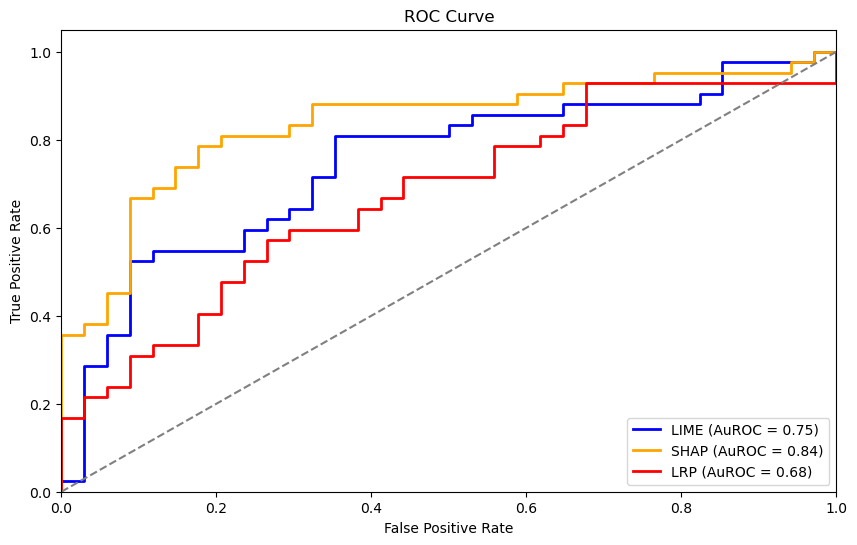

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(lime_fpr, lime_tpr, color='blue', lw=2, label=f'LIME (AuROC = {lime_roc_auc:.2f})')
plt.plot(shap_fpr, shap_tpr, color='orange', lw=2, label=f'SHAP (AuROC = {shap_roc_auc:.2f})')
plt.plot(lrp_fpr, lrp_tpr, color='red', lw=2, label=f'LRP (AuROC = {lrp_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig("ROC")
plt.show()

/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


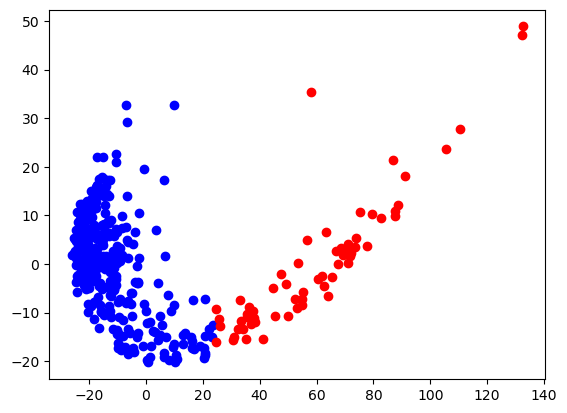

In [44]:

from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA

scaled_values = StandardScaler().fit_transform(lime_values_featureless)
pairwise_distances = squareform(pdist(scaled_values, "euclidean"))
cluster_evaluations = []

kmeans = KMeans(n_clusters=2).fit(pairwise_distances)
spectral_clusters = SpectralClustering(n_clusters=2, affinity="precomputed").fit(pairwise_distances)

pca = PCA(2)
#Transform the data
df = pca.fit_transform(pairwise_distances)
kmeans = KMeans(n_clusters= 2)
label = kmeans.fit_predict(df)
#filter rows of original data
filtered_label0 = df[label == 0]
filtered_label1 = df[label == 1]
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], color='blue')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1], color='red')

plt.show()


/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


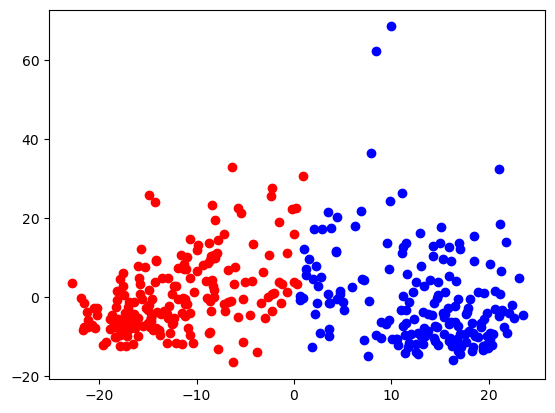

In [45]:
scaled_values = StandardScaler().fit_transform(shap_values_positive)
pairwise_distances = squareform(pdist(scaled_values, "euclidean"))
cluster_evaluations = []

kmeans = KMeans(n_clusters=2).fit(pairwise_distances)
spectral_clusters = SpectralClustering(n_clusters=2, affinity="precomputed").fit(pairwise_distances)

#Transform the data
df = pca.fit_transform(pairwise_distances)
label = kmeans.fit_predict(df)
#filter rows of original data
filtered_label0 = df[label == 0]
filtered_label1 = df[label == 1]
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], color='blue')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1], color='red')

plt.show()


/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


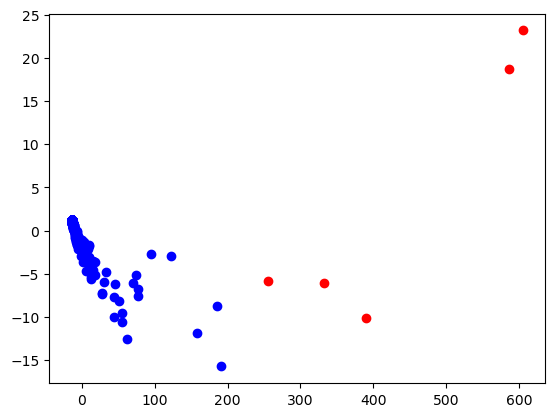

In [47]:
scaled_values = StandardScaler().fit_transform(attributions)
pairwise_distances = squareform(pdist(scaled_values, "euclidean"))
cluster_evaluations = []

kmeans = KMeans(n_clusters=2).fit(pairwise_distances)
spectral_clusters = SpectralClustering(n_clusters=2, affinity="precomputed").fit(pairwise_distances)

#Transform the data
df = pca.fit_transform(pairwise_distances)
label = kmeans.fit_predict(df)
#filter rows of original data
filtered_label0 = df[label == 0]
filtered_label1 = df[label == 1]
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], color='blue')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1], color='red')

plt.show()
